[INFO] Loading data...


Loading downtrend: 100%|██████████| 594/594 [00:39<00:00, 14.85it/s]


[INFO] Building end-to-end model...
[INFO] Training model...
Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.56225, saving model to models\8bougie_3strides_model_20250531_020107.keras
78/78 - 462s - 6s/step - accuracy: 0.5100 - loss: 0.7522 - val_accuracy: 0.5622 - val_loss: 0.7029 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_accuracy improved from 0.56225 to 0.63052, saving model to models\8bougie_3strides_model_20250531_020107.keras
78/78 - 395s - 5s/step - accuracy: 0.6546 - loss: 0.6412 - val_accuracy: 0.6305 - val_loss: 0.6698 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_accuracy improved from 0.63052 to 0.69076, saving model to models\8bougie_3strides_model_20250531_020107.keras
78/78 - 395s - 5s/step - accuracy: 0.7486 - loss: 0.5797 - val_accuracy: 0.6908 - val_loss: 0.6284 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_accuracy improved from 0.69076 to 0.71084, saving model to models\8bougie_3strides_model_20250531_020107.keras
78/78 - 394s - 5s

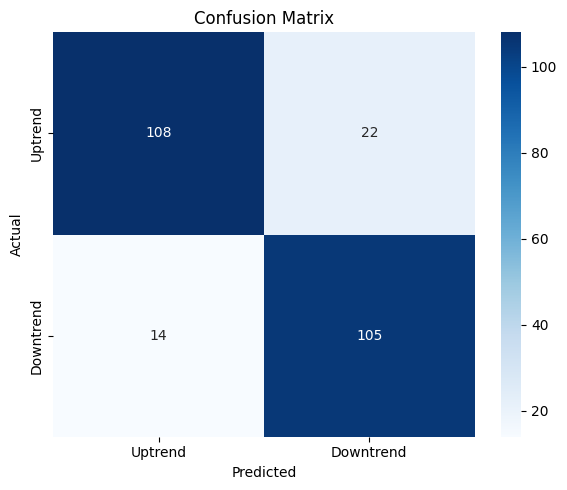

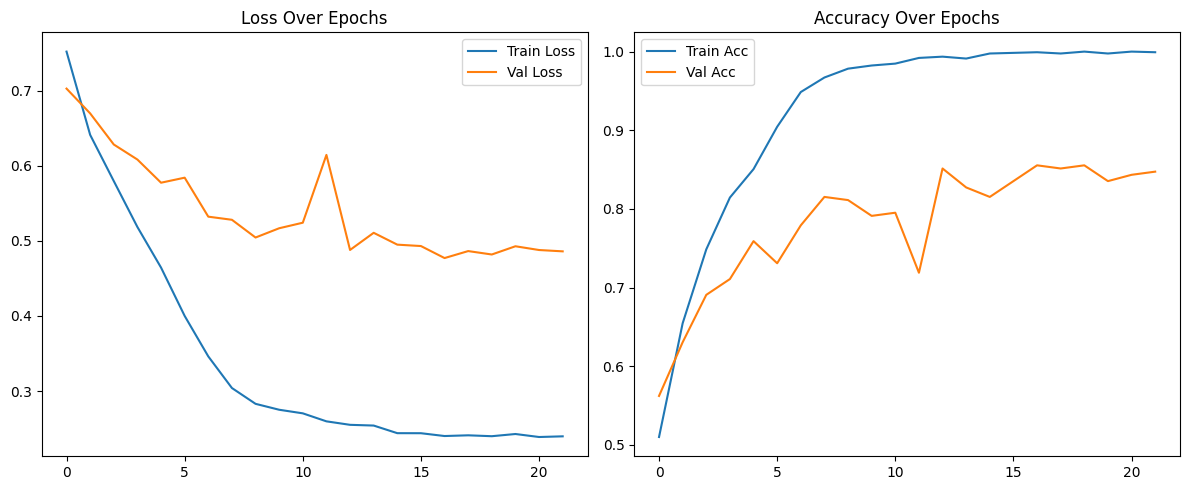

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, LSTM, Dense, Dropout, GlobalAveragePooling2D,
    BatchNormalization, Bidirectional
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# ====== CONFIG ======
SEQ_LEN = 5
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 30
NUM_CLASSES = 2
DATASET_DIR = 'dataset_8_Bougies_3\sequences'
MODEL_DIR = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_SAVE_PATH = os.path.join(MODEL_DIR, f'8bougie_3strides_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.keras')

# ====== DATA AUGMENTATION FUNCTION ======
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.clip_by_value(image, 0, 255)
    return image

# ====== DATA LOADING ======
def load_sequences(data_dir, augment=False):
    X, y = [], []
    class_map = {'uptrend': 0, 'downtrend': 1}
    for label in class_map:
        class_path = os.path.join(data_dir, label)
        for seq_folder in tqdm(os.listdir(class_path), desc=f"Loading {label}"):
            folder_path = os.path.join(class_path, seq_folder)
            sequence = []
            valid = True
            for i in range(SEQ_LEN):
                img_path = os.path.join(folder_path, f'img_{i}.png')
                if not os.path.exists(img_path):
                    valid = False
                    break
                img = load_img(img_path, target_size=IMG_SIZE)
                img = img_to_array(img)

                if augment:
                    img = augment_image(img)

                img = preprocess_input(img)
                sequence.append(img)
            if valid:
                X.append(sequence)
                y.append(class_map[label])
    return np.array(X), np.array(y)

print("[INFO] Loading data...")
X, y = load_sequences(DATASET_DIR, augment=False)
y_cat = to_categorical(y, num_classes=NUM_CLASSES)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

# Reload training set with augmentation and correct labels
X_aug, y_aug = load_sequences(DATASET_DIR, augment=True)
y_aug_cat = to_categorical(y_aug, num_classes=NUM_CLASSES)

# Utilise X_aug et y_aug_cat comme ensemble d'entraînement
X_train, y_train = X_aug, y_aug_cat


# ====== CLASS WEIGHTS ======
y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights = dict(enumerate(class_weights))

# ====== MODEL DEFINITION ======
print("[INFO] Building end-to-end model...")
def build_model():
    input_shape = (SEQ_LEN, *IMG_SIZE, 3)
    inputs = Input(shape=input_shape)

    base_cnn = ResNet50(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
    for layer in base_cnn.layers[:-10]:
        layer.trainable = False

    cnn = TimeDistributed(base_cnn)(inputs)
    pooled = TimeDistributed(GlobalAveragePooling2D())(cnn)
    norm = BatchNormalization()(pooled)

    x = Bidirectional(LSTM(128, return_sequences=False))(norm)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = build_model()
model.compile(
    optimizer=Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# ====== CALLBACKS ======
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True, monitor='val_accuracy', verbose=1)
]

# ====== TRAIN ======
print("[INFO] Training model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=2
)

# ====== EVALUATE ======
y_pred_probs = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred_probs, axis=1)

print("[INFO] Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Uptrend', 'Downtrend']))

# ====== CONFUSION MATRIX ======
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Uptrend", "Downtrend"], yticklabels=["Uptrend", "Downtrend"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ====== LEARNING CURVES ======
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()
